# Анализ оттока клиентов банка

**Банк столкнулся с проблемой большого оттока клиентов**

**Задача данного исследования:** провести анализ, выяснить причины оттока и выявить наиболее подверженные оттоку сегменты пользователей


**Презентация:** https://drive.google.com/file/d/1meO39QaPnedg8uUph8ccBJ4XXdiVcWGC/view?usp=sharing

**Дашборд:** https://public.tableau.com/app/profile/vadim8842/viz/finals_dash_YP/Dashboard1?publish=yes

### Декомпозиция


**1. Загрузка датасета, первичный анализ**

    - Сохранить исходные данные в датафрейм
    - Ознакомиться с данными, проверить корректность их загрузки


**2. Предобработка данных**

    - Изучить данные на предмет наличия явных и неявных дубликатов
    - Рассмотреть пропущенные значения, установить их природу, по возможности произвести замену
    - Проверить данные на наличие выбросов, корректность заполнения полей
    - Произвести кодирование необходимых столбцов
    
    
**3. EDA (Исследовательский анализ данных)**

    - Изучить распределения признаков, а также распределения признаков в разрезе оттока
    - Провести корреляционный анализ, выявить наиболее коррелирующие с оттоком признаки
    - Построить несколько моделей классификации, выявить наиболее влияющие на отток признаки
    - Построить дендрограмму, по которой можно будет принять решение по количеству кластеров, затем обучить алгоритм кластеризации и изучить признаки получившихся кластеров
    - Исходя из проведенного анализа, определить наиболее значимые параметры, вляющие на отток, сформировать сегменты клиентов, которые склонны уходить из банка


**4. Проверка гипотез**
    
    - Проверить гипотезу о том, что уровень дохода клиента влияет на отток
    - Проверить гипотезу о том, что возраст клиента влияет на отток
    - Проверить гипотезу о том, что активность клиента влияет на отток
    - При нахождении в данных других интересных закономерностей, проверить иные гипотезы, которые могут помочь понять причины оттока
    
   
**5. Выводы и рекомендации для бизнеса**
    
    - Выделить наиболее влияющие на отток признаки
    - Выделить сегменты клиентов, которые уходят чаще всего и реже всего
    - Предложить несколько вероятных вариантов решения проблемы оттока, сообщить об интересных инсайтах, найденных в ходе анализа
    


## Загрузка датасета, первичный анализ

In [1]:
# Импортируем необходимые библиотеки
!pip install phik
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import phik
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn import tree
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.cluster import KMeans, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage

from scipy.stats import ttest_ind
from scipy.stats import norm

warnings.filterwarnings("ignore")

In [2]:
# Загружаем данные
df = pd.read_csv('/datasets/bank_scrooge.csv')

Рассмотрим информацию о датасете

In [3]:
df.sample(5)

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
6460,118579,772.0,Рыбинск,Ж,45.0,4,1212825.11,2,0,0,203176.78,0
6491,181055,935.0,Ярославль,М,48.0,0,NaN,1,1,0,133629.47,0
3585,141274,826.0,Ростов,Ж,50.0,5,525926.00,1,1,1,142512.10,0
9029,166312,818.0,Ярославль,Ж,40.0,1,123237.27,3,0,0,77016.89,0
4020,203314,857.0,Ярославль,М,32.0,5,3259830.65,2,1,1,378274.87,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


In [5]:
df.describe()

,USERID,score,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
count,10000.00000,10000.000000,9974.000000,10000.000000,7.705000e+03,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000
mean,171814.71260,848.699400,42.734409,2.627600,8.277943e+05,1.870100,0.680400,0.523500,1.478669e+05,0.182000
std,33708.23812,65.448519,12.179971,1.980836,1.980614e+06,0.792647,0.466345,0.499472,1.393885e+05,0.385864
min,94561.00000,642.000000,18.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,2.546300e+03,0.000000
25%,142810.25000,802.000000,33.000000,0.000000,2.955542e+05,1.000000,0.000000,0.000000,7.525190e+04,0.000000
50%,172728.00000,853.000000,40.000000,3.000000,5.242722e+05,2.000000,1.000000,1.000000,1.196581e+05,0.000000
75%,201261.75000,900.000000,51.000000,4.000000,9.807058e+05,2.000000,1.000000,1.000000,1.745005e+05,0.000000
max,229145.00000,1000.000000,86.000000,9.000000,1.191136e+08,5.000000,1.000000,1.000000,1.395064e+06,1.000000


**Вывод:** Типы данных у всех колонок определены корректно, наблюдается большое количество пропусков в balance, age - надо найти способ заполнить их. Также необходимо привести заголовки столбцов в нижний регистр, проверить данные на предмет ошибок заполнения, и закодировать некоторые поля one-hot методом для корректности корреляционного анализа и построения моделей.

## Предобработка данных

In [6]:
# Проверим, что во всех полях находятся корректные значения
print('Уникальные значения')
for col in df.columns:
    print(f'Колонка {col}:\n', df[col].unique(), '\n')

Уникальные значения
Колонка USERID:
 [183012 146556 120722 ... 115639 148700  96267] 

Колонка score:
 [ 850.  861.  892.  866.  730.  856.  807.  825.  923.  906.  927.  921.
  845.  837.  815.  731.  829.  793.  876.  922.  772.  896.  871.  732.
  898.  806.  766.  776.  868.  946.  828.  786.  944.  863.  822.  794.
  924.  811.  814.  956.  935.  826.  849.  901.  893.  792.  888.  831.
  748.  820.  860.  914.  930.  948.  789.  737.  812.  933.  809.  749.
  873.  859.  950.  937.  835.  768.  767.  785.  846.  750.  816.  894.
  891.  788.  758.  787.  821.  855.  779.  791.  838.  971.  797.  841.
  915.  985.  870.  897.  763.  774.  686. 1000.  875.  819.  869.  854.
  810.  761.  802.  958.  917.  745.  736.  908.  928.  884.  853.  780.
  726.  881.  975.  852.  965.  899.  890.  836.  818.  880.  795.  916.
  775.  902.  918.  842.  771.  895.  801.  721.  966.  804.  885.  986.
  753.  832.  979.  798.  754.  756.  823.  658.  734.  954.  827.  929.
  760.  688.  659.  8

Ошибок в значениях полей не наблюдается

In [7]:
# Переведем названия колонок в нижний регистр
df.columns = df.columns.str.lower()
df.sample()

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
5089,206102,921.0,Ярославль,М,30.0,4,1854172.17,2,1,0,139826.89,0


In [8]:
# Проверим наличие дублирующихся строк
df.duplicated().sum()

0

In [9]:
# Проверим наличие дублирующихся id
print(df.userid.duplicated().sum())
df[df['userid'].duplicated(keep=False)].sort_values('userid').head(20)

73


,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
1893,116540,883.0,Рыбинск,Ж,55.0,1,362756.49,3,0,1,175920.48,1
7694,116540,887.0,Ярославль,Ж,38.0,0,NaN,1,0,1,119247.61,0
7542,117943,880.0,Ярославль,Ж,40.0,0,NaN,1,1,0,137718.93,0
4866,117943,855.0,Рыбинск,Ж,32.0,6,1036832.93,4,1,1,107792.71,1
5896,120258,905.0,Ярославль,М,30.0,0,NaN,1,1,1,146427.96,0
5863,120258,908.0,Рыбинск,Ж,38.0,4,2213581.63,2,0,1,160327.77,1
1411,123461,829.0,Ярославль,Ж,59.0,0,96222.44,2,0,1,102771.55,1
8638,123461,934.0,Рыбинск,М,34.0,0,NaN,2,1,0,291619.27,0
8164,124450,859.0,Ярославль,Ж,38.0,6,516811.20,1,1,1,95144.63,1
9775,124450,758.0,Рыбинск,Ж,36.0,0,73574.07,2,0,1,79963.59,0


In [10]:
# Проверим, что люди с дублирующимися идентификаторами из разных городов
df[df['userid'].duplicated(keep=False)].groupby(['userid', 'city'])['userid', 'city'].count().sum()

userid    146
city      146
dtype: int64

73 пары дублирующихся идентификаторов - казалось бы, что тогда и данные у этих пар должны дублироваться, но этого не происходит.эти строки как есть. **Вполне вероятная причина возникновения ошибки в том, что выгрузки по клиентам происходили из БД каждого города, то есть БД по каждому городу имеет свою идентификацию клиентов**. Если бы данные дублировались, то следовало бы избавиться от дубликатов, но здесь это не так, поэтому мы оставим все строки как есть.

In [11]:
# Поскольку карта является продуктом, то проверим наличие случаев, когда карта есть, а продуктов нет
df.query('products == 0 and credit_card == 1')

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn


In [12]:
# Проверим, есть ли клиенты с 0 продуктов
df.query('products == 0')

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
8957,147837,962.0,Рыбинск,Ж,79.0,3,NaN,0,0,0,25063.96,1


Внезапно, такой клиент есть. Клиентом банка считается только человек, который имеет как минимум 1 продукт - удалим его из данных

In [13]:
df = df.query('products != 0')

In [14]:
# Проверим пропуски в возрасте
df[df['age'].isna()]

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
1247,228075,932.0,Ярославль,М,NaN,5,7601719.20,2,1,1,408121.16,0
2165,187635,692.0,Рыбинск,Ж,NaN,0,NaN,1,1,1,160368.82,0
2444,221156,913.0,Ярославль,М,NaN,0,NaN,1,1,1,135693.24,0
3091,138660,836.0,Ростов,Ж,NaN,5,294315.53,2,0,1,63310.22,1
4912,210674,834.0,Рыбинск,М,NaN,1,238330.52,2,0,1,93775.06,0
5470,218868,827.0,Рыбинск,Ж,NaN,4,448959.07,2,1,1,67835.95,0
5495,151662,884.0,Рыбинск,Ж,NaN,0,NaN,1,1,1,137500.77,0
7236,210135,908.0,Рыбинск,Ж,NaN,4,1120340.31,3,1,1,85002.15,0
7248,219343,920.0,Рыбинск,Ж,NaN,0,NaN,1,1,0,159248.67,0
7345,184913,829.0,Ярославль,Ж,NaN,3,188648.77,2,0,1,75206.90,0


Между пропусками в возрасте нет взаимосвязи, возможно имеет место сбой при выгрузке, ведь банк имеет паспортные данные всех клиентов и чётко знает возраст. Таких пропусков немного, почти все клиенты неотточные, да и заменять возраст на что-то некорректно - можем удалить эти строки.

In [15]:
df = df.dropna(subset=['age'])

In [16]:
df[df['age'].isna()]

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn


**Детальнее рассмотрим пропуски в балансе**

In [17]:
# Изучим строки с пропущенным балансом
print(df[df['balance'].isna()]['userid'].count())
df[df['balance'].isna()].sample(15)

2278


,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
9144,154992,922.0,Ярославль,М,31.0,0,NaN,1,1,0,238496.86,0
5605,129807,903.0,Ярославль,М,39.0,0,NaN,2,0,1,202566.92,0
2280,143388,910.0,Ярославль,М,30.0,0,NaN,1,1,1,107600.30,0
5905,180640,664.0,Рыбинск,Ж,32.0,0,NaN,1,1,1,229845.39,0
2788,223930,722.0,Рыбинск,М,49.0,0,NaN,1,1,0,287914.59,0
6568,194996,953.0,Ярославль,Ж,26.0,0,NaN,1,1,0,46779.53,0
8862,216830,880.0,Ярославль,М,51.0,0,NaN,1,1,0,236494.14,0
2948,118559,733.0,Ярославль,Ж,42.0,0,NaN,1,1,0,206012.14,0
4523,218987,909.0,Рыбинск,Ж,33.0,0,NaN,2,1,0,128771.89,0
223,180144,921.0,Ярославль,Ж,62.0,0,NaN,1,0,1,85312.42,0


In [18]:
# Посмотрим, в каких городах пропущены значения
df[df['balance'].isna()].groupby('city')['userid'].count()

city
Ростов        235
Рыбинск       585
Ярославль    1458
Name: userid, dtype: int64

Изучим распределение баланса

Среднее: 827245.5875152696
Медиана: 524295.33


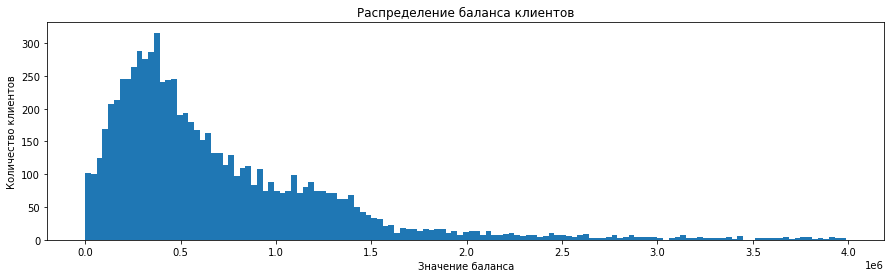

In [19]:
plt.figure(figsize=(15, 4))
df['balance'].plot(kind='hist', bins=np.arange(0, 4e6, 3e4))
plt.xlabel('Значение баланса')
plt.ylabel('Количество клиентов')
plt.title('Распределение баланса клиентов')

print('Среднее:', df.balance.mean())
print('Медиана:', df.balance.median())

Судя по графикам, значения баланса распределены нормально в обоих городах.

Для заполнения пропущенных значений сформируем группы по признакам **city, gender, products, last_activity, equity, credit_card** - это позволит нам не так сильно исказить распределение. Для некоторых групп, вероятно, не найдётся людей - для них мы заполним пропуски средним значением по балансу, поскольку их не должно быть слишком много.

Если включать в признаки для деления групп **score, age** - количество незаполненных значений будет сильно больше, это было проверено экспериментально :)

In [20]:
df.head()

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


In [21]:
df['balance'] = df.groupby(['city', 'gender', 'products', 'last_activity', 'equity', 'credit_card'])\
['balance'].transform(lambda x: x.fillna(x.median()))
df['balance'].isna().sum()

133

In [22]:
# Заменим оставшиеся пропуски средним - их не так уж и много
df['balance'] = df['balance'].fillna(df['balance'].mean())

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9973 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   userid         9973 non-null   int64  
 1   score          9973 non-null   float64
 2   city           9973 non-null   object 
 3   gender         9973 non-null   object 
 4   age            9973 non-null   float64
 5   equity         9973 non-null   int64  
 6   balance        9973 non-null   float64
 7   products       9973 non-null   int64  
 8   credit_card    9973 non-null   int64  
 9   last_activity  9973 non-null   int64  
 10  est_salary     9973 non-null   float64
 11  churn          9973 non-null   int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 1012.9+ KB


Среднее: 677827.3797997967
Медиана: 390643.0


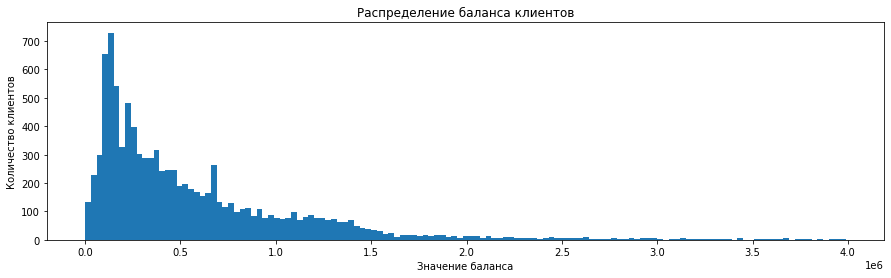

In [24]:
plt.figure(figsize=(15, 4))
df['balance'].plot(kind='hist', bins=np.arange(0, 4e6, 3e4))
plt.xlabel('Значение баланса')
plt.ylabel('Количество клиентов')
plt.title('Распределение баланса клиентов')

print('Среднее:', df.balance.mean())
print('Медиана:', df.balance.median())

Успешно, насколько это было возможным, заменили пропуски в балансе!

In [25]:
# Сохраним колонку с городами для удобства при дальнейшей работе
city_save = df['city']

# Закодируем переменные
df = pd.get_dummies(df)
df['city_save'] = city_save
df['city_save_num'] = 0
df.loc[df['city_save']=='Ярославль', 'city_save_num'] = 2
df.loc[df['city_save']=='Рыбинск', 'city_save_num'] = 1
df.loc[df['city_save']=='Ростов', 'city_save_num'] = 0
df.head()

,userid,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,city_Ростов,city_Рыбинск,city_Ярославль,gender_Ж,gender_М,city_save,city_save_num
0,183012,850.0,25.0,1,59214.82,2,0,1,75719.14,1,0,1,0,1,0,Рыбинск,1
1,146556,861.0,37.0,5,850594.33,3,1,0,86621.77,0,0,1,0,1,0,Рыбинск,1
2,120722,892.0,30.0,0,147227.09,1,1,1,107683.34,0,0,1,0,1,0,Рыбинск,1
3,225363,866.0,51.0,5,1524746.26,2,0,1,174423.53,1,0,0,1,1,0,Ярославль,2
4,157978,730.0,34.0,5,174.00,1,1,0,67353.16,1,0,0,1,0,1,Ярославль,2


**Вывод:** в ходе предобработки мы столкнулись ошибками с дублирующимися идентификаторами пользователей (скорее всего, это связано с тем, что идентификаторы для каждого города формируются независимо от других), пропусками в возрасте (возможная ошибка при формировании выгрузки), а также с клиентом, не имеющим ни одного продукта. Помимо этого, мы столкнулись с большим количеством пропусков в балансе пользователей - скорее всего, тоже имеет место быть ошибка при выгрузке в этих городах, данную информацию следует уточнить, и в случае чего скорректировать обработку пропусков.

## EDA (Исследовательский анализ данных)

### Распределения признаков

Изучим, как распределены признаки, а также рассмотрим распределение признаков в разрезе оттока - это поможет нам в составлении портретов клиентов, которые чаще всего уходят от нас.

In [26]:
df.groupby('churn')['score'].mean()

churn
0    845.396199
1    863.361936
Name: score, dtype: float64

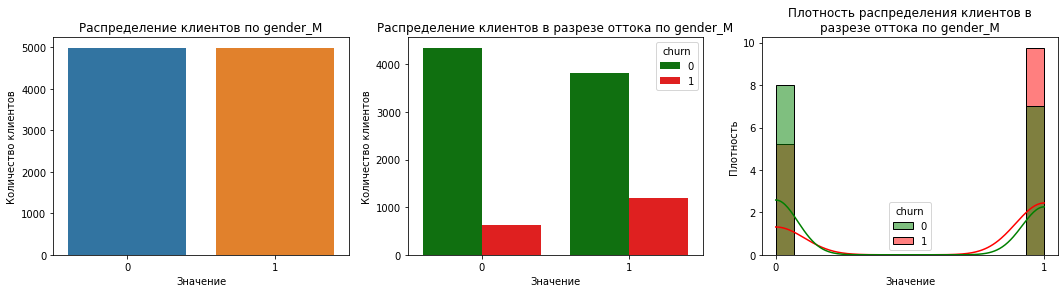

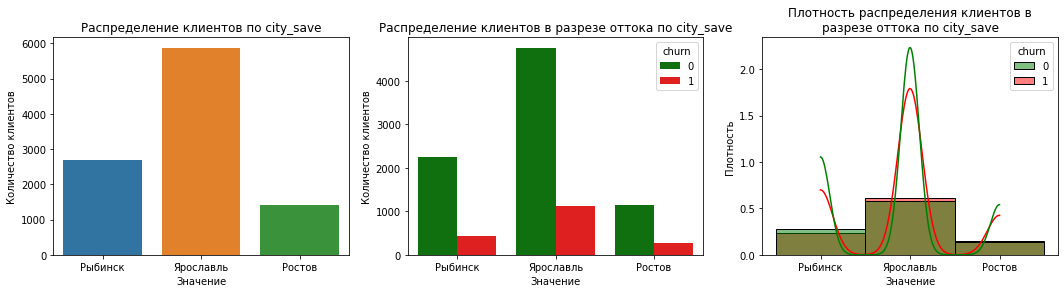

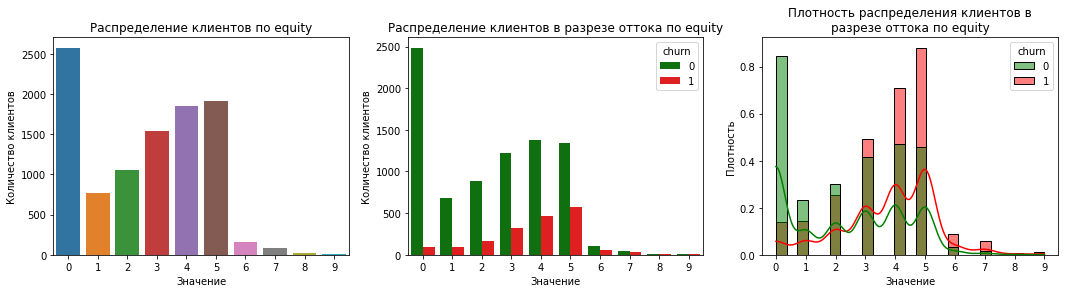

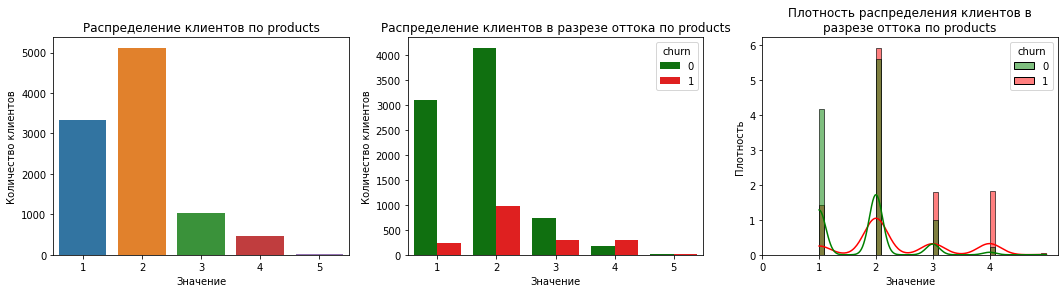

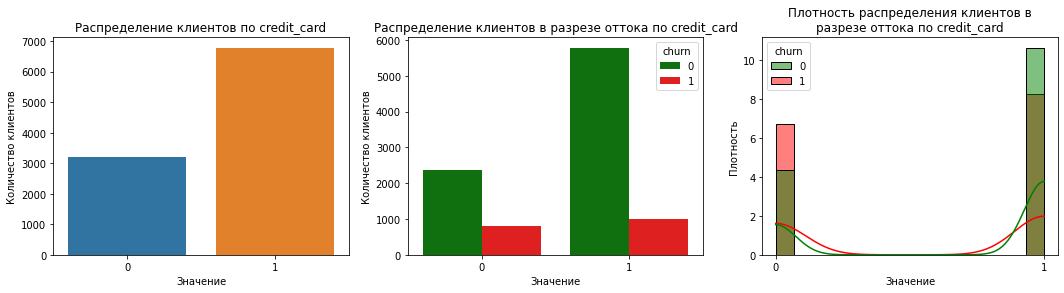

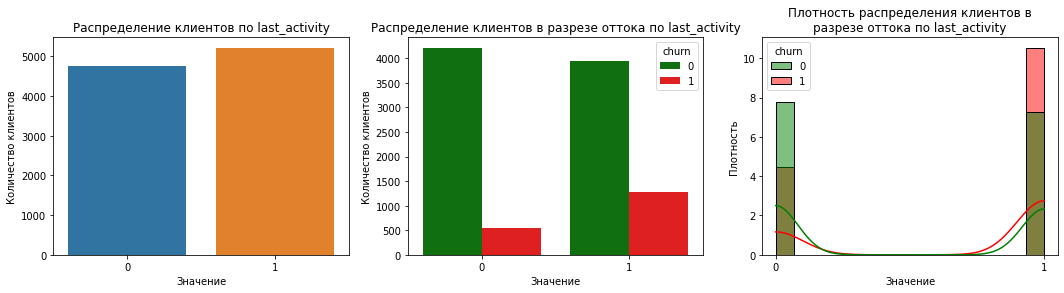

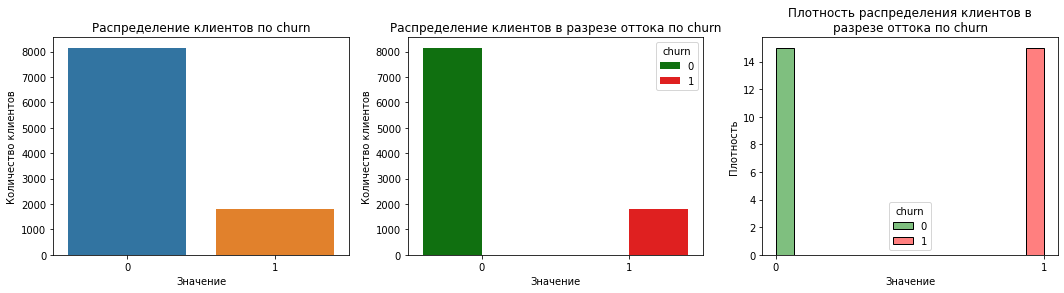

In [27]:
# Распределения категориальных признаков
for col in ['gender_М', 'city_save', 'equity', 'products', 'credit_card', 'last_activity', 'churn']:
    f, axs = plt.subplots(1, 3, figsize=(18, 4))
    
    sns.countplot(data=df, x=col, ax=axs[0])
    sns.countplot(data=df, x=col, hue='churn', ax=axs[1], palette=["green", "red"])
    sns.histplot(data=df, x=col, stat="density", common_norm=False, hue='churn', 
                 palette=['green', 'red'], kde=True, ax=axs[2])
    axs[0].set_title('Распределение клиентов по ' + col)
    axs[0].set_xlabel('Значение')
    axs[0].set_ylabel('Количество клиентов')
    axs[1].set_title('Распределение клиентов в разрезе оттока по ' + col)
    axs[1].set_xlabel('Значение')
    axs[1].set_ylabel('Количество клиентов')
    axs[2].set_xticks(ticks=np.arange(0, len(df[col].unique()), 1))
    axs[2].set_title('Плотность распределения клиентов в\nразрезе оттока по ' + col)
    axs[2].set_xlabel('Значение')
    axs[2].set_ylabel('Плотность')
    
    plt.show()

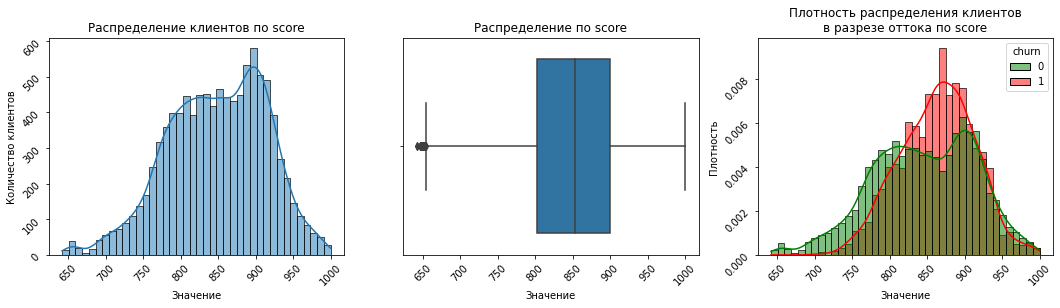

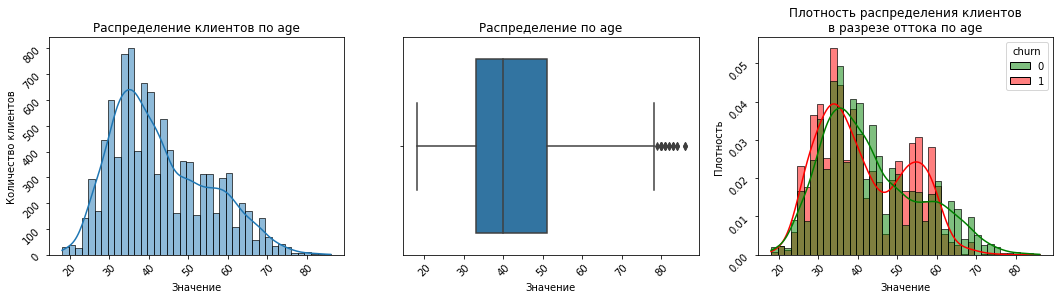

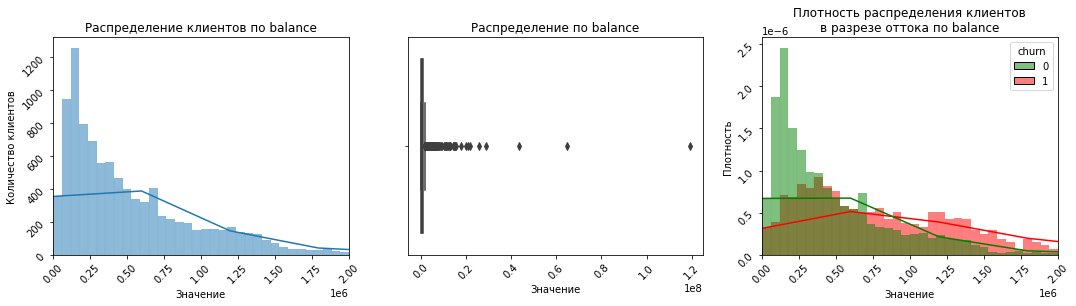

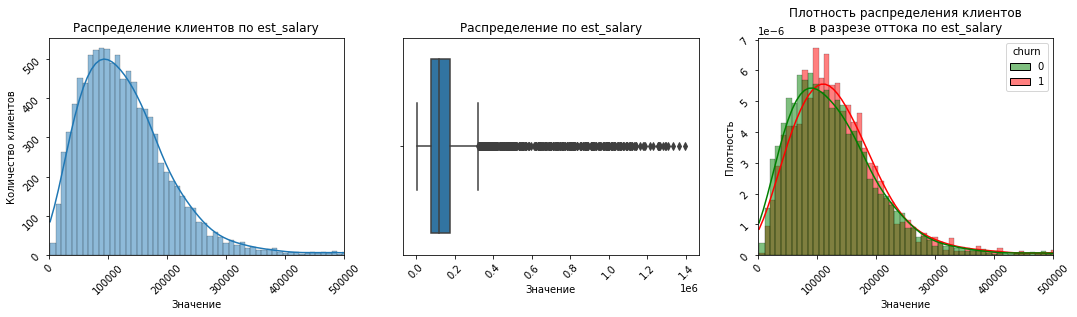

In [28]:
# Распределения количественных признаков
for col in ['score', 'age', 'balance', 'est_salary']:
    f, axs = plt.subplots(1, 3, figsize=(18, 4))
    
    
    sns.histplot(x=df[col], kde=True, ax=axs[0])
    sns.boxplot(x=df[col], ax=axs[1])
    sns.histplot(data=df, x=col, kde=True, stat='density', common_norm=False, 
                 hue='churn', palette=['green', 'red'], ax=axs[2])
    axs[0].set_title('Распределение клиентов по ' + col)
    axs[0].set_xlabel('Значение')
    axs[0].set_ylabel('Количество клиентов')
    axs[0].tick_params(labelrotation=45)
    axs[1].set_title('Распределение по ' + col)
    axs[1].set_xlabel('Значение')
    axs[1].tick_params(labelrotation=45)
    axs[2].set_title('Плотность распределения клиентов\nв разрезе оттока по ' + col)
    axs[2].set_xlabel('Значение')
    axs[2].set_ylabel('Плотность')
    axs[2].tick_params(labelrotation=45)
    if col == 'balance':
        axs[0].set_xlim(0, 0.2e7)
        axs[2].set_xlim(0, 0.2e7)
    elif col == 'est_salary':
        axs[0].set_xlim(0, 0.5e6)
        axs[2].set_xlim(0, 0.5e6)

In [30]:
print(f'Общий уровень оттока по банку: {(df[df["churn"] == 1].shape[0] / df.shape[0] * 100):.2f}%')

Общий уровень оттока по банку: 18.23%


**Вывод**

Исходя из распределений, можно выявить следующие особенности:
- Мужчины уходят чаще женщин
- Ярославль - больше всего ушедших клиентов, однако это самый большой город по численности клиентов
- С ростом баллов собственности растёт частота ухода клиентов
- Как ни странно, с ростом количества используемых клиентом продуктов растёт частота оттока. Следует обратить внимание, что среди клиентов с 4 продуктами ушедших клиентов больше, чем оставшихся.
- Частота ухода клиентов без кредитки выше
- Активные клиенты, как правило, уходят чаще неактивных

- У ушедших клиентов чаще всего в районе 850-925 очков скоринга
- Явно заметно, что есть большой отток среди клиентов от 45 до 60 лет

Для того, чтобы более чётко убедиться во влиянии конкретных факторов на отток и для формирования сегментов, необходимо изучить данные другими методами, в частности рассмотреть корреляции признаков, построить несколько моделей машинного обучения и рассмотреть важность каждого признака.

### Корреляционный анализ

Для наглядности построим тепловую карту матрицы корреляций

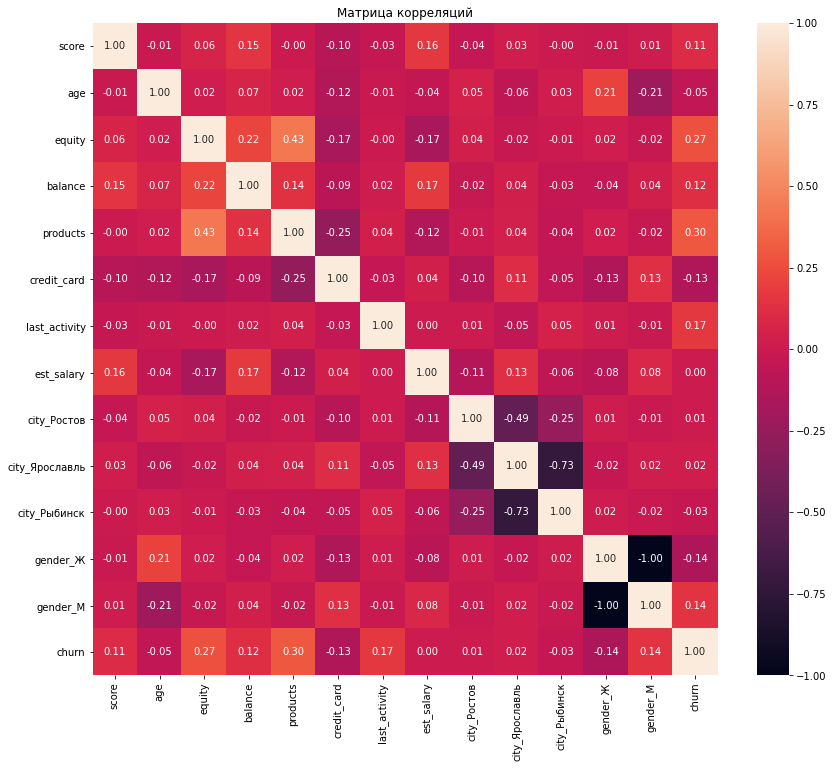

In [31]:
plt.figure(figsize=(14,12))
plt.title('Матрица корреляций')
sns.heatmap(df[['score', 'age', 'equity', 'balance', 'products', 'credit_card', 'last_activity', 'est_salary', 
                'city_Ростов', 'city_Ярославль', 'city_Рыбинск', 'gender_Ж', 'gender_М', 'churn']].corr(),
            annot=True, fmt=".2f")
plt.show()

**Вывод**

**Нет признаков, которые сильно бы коррелировали с оттоком**. Тем не менее, больше всего с оттоком коррелируют количество продуктов и количество баллов собственности, хотя по шкале Чеддока данную корреляцию следует называть слабой. Также имеется небольшая корреляция с активностью клиента, полом, наличием кредитной карты, балансом и скорингом. Остальные корреляции близки к нулю.

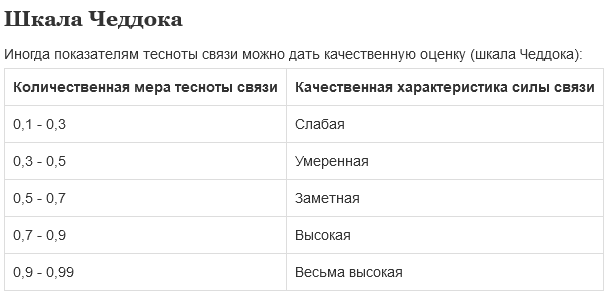

Попробуем посчитать **phik-корреляцию** - более универсальный и новый метод, суть которого базируется на подсчете хи-квадрат статистики, затем ее трансформации в нечто подобное коэффициенту корреляции только на отрезке от 0 (нулевая взаимосвязь) до 1 (максимальная взаимосвязь).

interval columns not set, guessing: ['score', 'age', 'equity', 'balance', 'products', 'credit_card', 'last_activity', 'est_salary', 'city_Ростов', 'city_Ярославль', 'city_Рыбинск', 'gender_Ж', 'gender_М', 'churn']


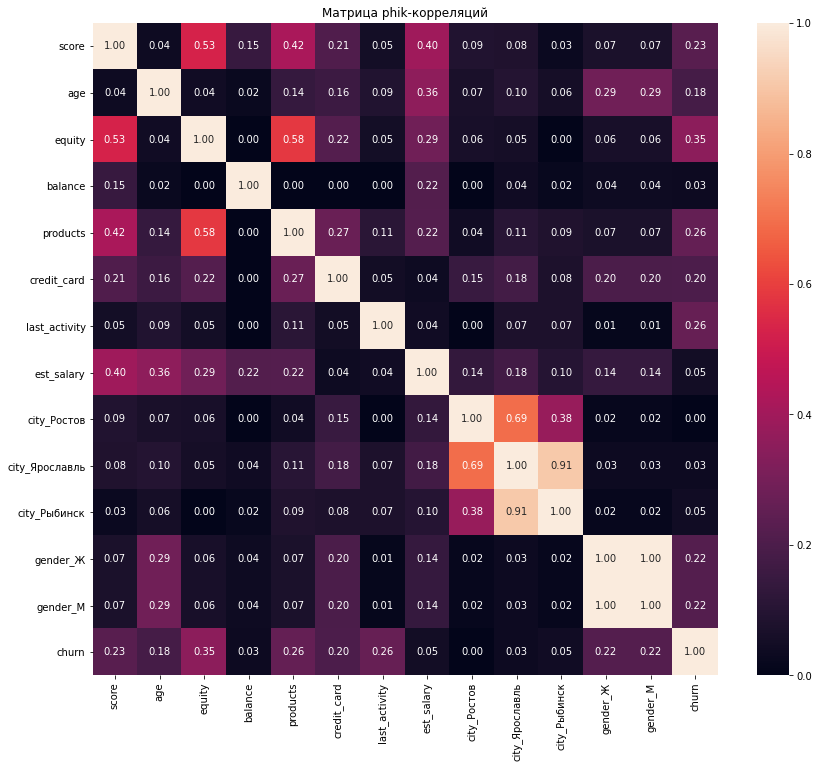

In [32]:
plt.figure(figsize=(14,12))
plt.title('Матрица phik-корреляций')
sns.heatmap(df[['score', 'age', 'equity', 'balance', 'products', 'credit_card', 'last_activity', 'est_salary', 
                'city_Ростов', 'city_Ярославль', 'city_Рыбинск', 'gender_Ж', 'gender_М', 'churn']].phik_matrix(),
            annot=True, fmt=".2f")
plt.show()

**Вывод**

**Результаты изменились не сильно:** наиболее коррелирующим признаком оказалось количество баллов собственности, далее в равной степени с оттоком коррелируют количество продуктов у клиента и его активность. Также есть корреляция с количеством очков скоринга, полом и возрастом клиента. Стоит обратить внимание, что при данном методе расчёта баланс клиента близкую к нулю в отличие от классического метода. Остальные корреляции также близки к нулевым.

### Модели для предсказания оттока клиентов и кластеризации

#### Классификация

Попробуем сравнить несколько моделей разной сложности, чтобы получить наилучшее качество классификации и выявить наиболее важные признаки, которые выделят модели.

In [33]:
df.head()

,userid,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,city_Ростов,city_Рыбинск,city_Ярославль,gender_Ж,gender_М,city_save,city_save_num
0,183012,850.0,25.0,1,59214.82,2,0,1,75719.14,1,0,1,0,1,0,Рыбинск,1
1,146556,861.0,37.0,5,850594.33,3,1,0,86621.77,0,0,1,0,1,0,Рыбинск,1
2,120722,892.0,30.0,0,147227.09,1,1,1,107683.34,0,0,1,0,1,0,Рыбинск,1
3,225363,866.0,51.0,5,1524746.26,2,0,1,174423.53,1,0,0,1,1,0,Ярославль,2
4,157978,730.0,34.0,5,174.00,1,1,0,67353.16,1,0,0,1,0,1,Ярославль,2


In [34]:
# Формируем фичи и таргет
X = df.drop(['churn', 'city_save', 'userid', 'city_save_num'], axis = 1)
y = df['churn']

In [35]:
# Делим выборки на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

In [36]:
# Функция подсчёта метрик
def metrics(y_true, y_pred, y_proba):
    print('Метрики классификации')
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))

Важно обратить внимание, что **Accuracy в нашем случае не несёт большого смысла, поскольку в данных наблюдается дисбаланс таргета** - модель может всегда говорить, что клиент остался, и при этом иметь достаточно хороший Accuracy! В нашем случае судить о качестве следует больше по другим метрикам.

In [37]:
# Определим модель логистической регрессии
lr_model = LogisticRegression(random_state = 0)
# Обучим модель
lr_model.fit(X_train_st, y_train)

# Предскажем метки классов и их вероятности
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:,1]

# Метрики качества
metrics(y_test, lr_predictions, lr_probabilities)

# Важность признаков
print('Важность признаков:\n', pd.DataFrame(({'cols':X_train.columns, 'coefs':lr_model.coef_[0]}))\
      .sort_values('coefs', ascending=False, key=abs))

Метрики классификации
	Accuracy: 0.83
	Precision: 0.65
	Recall: 0.27
	F1: 0.38
	ROC_AUC: 0.79
Важность признаков:
               cols     coefs
2           equity  0.578347
4         products  0.524299
6    last_activity  0.523699
0            score  0.309413
11        gender_Ж -0.234492
12        gender_М  0.234492
5      credit_card -0.194214
1              age -0.082187
3          balance  0.080478
9     city_Рыбинск -0.060489
10  city_Ярославль  0.037778
8      city_Ростов  0.023118
7       est_salary  0.006878


Логистическая регрессия - одна из самых простых моделей. Несмотря на хороший Accuracy, модель имеет достаточно низкий Recall и не лучший Precision. Среди самых важных признаков - количество баллов собственности, количество продуктов и активность клиента, маловажными модель посчитала зарплату и местоположение клиента.

Попробуем воспользоваться более сложной моделью с другим подходом - обучим решающее дерево. Также для улучшение качества воспользуемся подбором гиперпараметров.

In [38]:
# Работа этой ячейки может занимать некоторое время из-за перебора гиперпараметров

# Определим подбираемые гиперпараметры
tree_para = {'criterion':['gini', 'entropy', 'log_loss'], 
             'max_depth':[1,2,3,4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}

# Мы будем перебирать все гиперпараметры для поиска оптимальных методом GridSearch
dtc_cv = GridSearchCV(DecisionTreeClassifier(random_state=0), tree_para, cv=5)
dtc_cv.fit(X_train_st, y_train)

# Подобранные гиперпараметры, метрики и важность признаков
print('Гиперпараметры:', dtc_cv.best_params_)
metrics(y_test, dtc_cv.predict(X_test_st), dtc_cv.predict_proba(X_test_st)[:,1])
print('Важность признаков:\n', pd.DataFrame(({'cols':X_train.columns, 'coefs':dtc_cv.best_estimator_.feature_importances_}))\
      .sort_values('coefs', ascending=False))

Гиперпараметры: {'criterion': 'entropy', 'max_depth': 8}
Метрики классификации
	Accuracy: 0.84
	Precision: 0.64
	Recall: 0.41
	F1: 0.50
	ROC_AUC: 0.85
Важность признаков:
               cols     coefs
0            score  0.244344
3          balance  0.198454
1              age  0.109008
4         products  0.104042
6    last_activity  0.086680
2           equity  0.075692
5      credit_card  0.055302
7       est_salary  0.047612
11        gender_Ж  0.032099
12        gender_М  0.027377
10  city_Ярославль  0.013388
9     city_Рыбинск  0.006002
8      city_Ростов  0.000000


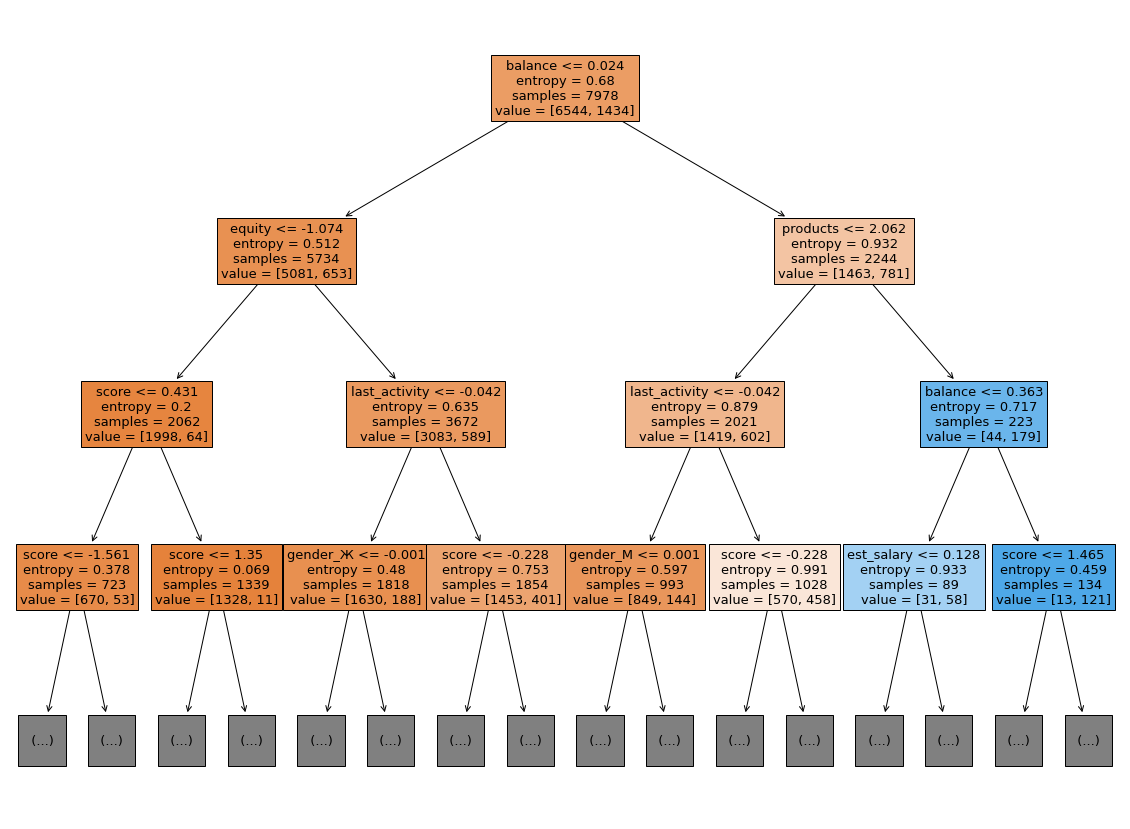

In [39]:
# Для наглядности так же построим несколько верхних уровней дерева
fig = plt.figure(figsize=(20,15))
_ = tree.plot_tree(dtc_cv.best_estimator_, 
                   feature_names=df.drop(['churn', 'city_save', 'userid', 'city_save_num'], axis=1).columns, 
                   filled=True,
                   fontsize=13, max_depth=3)

Качество модели стало лучше - метрики выросли. По таблице важности признаков и верхним уровням дерева видно, что модель изначально делит всех клиентов по балансу, затем по количеству баллов собственности и количеству продуктов. Далее, важными признаками для модели являются количество баллов скоринга, активность, что также видно по дереву. Также интересно, что модель "отбросила" факт проживания в Ростове (коэф. 0).

Попробуем классифицировать при помощи ансамблевых алгоритмов - воспользуемся случайным лесом, также подберём гиперпараметры.

In [40]:
# Работа этой ячейки может занимать некоторое время из-за перебора гиперпараметров

# Определим подбираемые гиперпараметры
param_grid = { 
    'n_estimators': list(np.linspace(10, 1200, 10, dtype = int)),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : list(np.linspace(1, 1200, 10, dtype = int)) + [None],
    'criterion' :['gini', 'entropy']
}

# Мы будем перебирать 10 случайных комбинаций гиперпараметров для поиска методом RandomizedSearch
rfс_cv = RandomizedSearchCV(RandomForestClassifier(random_state=0), param_grid, cv=5, verbose=0, n_jobs=-1, random_state=0)
rfс_cv.fit(X_train_st, y_train)

# Подобранные гиперпараметры, метрики и важность признаков
print('Гиперпараметры:', rfс_cv.best_estimator_)
metrics(y_test, rfс_cv.predict(X_test_st), rfс_cv.predict_proba(X_test_st)[:,1])
print('Важность признаков:\n', pd.DataFrame(({'cols':X_train.columns, 'coefs':rfс_cv.best_estimator_.feature_importances_}))\
      .sort_values('coefs', ascending=False))

Гиперпараметры: RandomForestClassifier(criterion='entropy', max_depth=933, n_estimators=935,
                       random_state=0)
Метрики классификации
	Accuracy: 0.88
	Precision: 0.81
	Recall: 0.47
	F1: 0.59
	ROC_AUC: 0.87
Важность признаков:
               cols     coefs
0            score  0.196855
3          balance  0.184970
7       est_salary  0.142298
1              age  0.137671
2           equity  0.095222
4         products  0.084666
6    last_activity  0.056780
5      credit_card  0.028242
11        gender_Ж  0.017709
12        gender_М  0.016223
10  city_Ярославль  0.014741
9     city_Рыбинск  0.014623
8      city_Ростов  0.010001


Случайный лес показал лучшее качество, однако среди важных признаков наиболее важными, помимо очков скоринга и баланса, стала зарплата клиента - у других моделей эти признаки не играли столь большую роль.


#### Кластеризация
Попробуем иной подход - воспользуемся алгоритмом k-средних и кластеризуем клиентов по их признакам

In [41]:
# Сформируем выборку без столбца с оттоком для корректной кластеризации
#df = df.drop('cluster', axis=1)
df_cl = df.drop(['churn', 'city_Рыбинск', 'city_Ярославль', 'city_Ростов', 'gender_Ж','userid', 'city_save'], axis = 1)
#df_cl['city_save'] = df_cl['city_save'].astype(int)
df_cl.sample(5)

,score,age,equity,balance,products,credit_card,last_activity,est_salary,gender_М,city_save_num
8440,800.0,30.0,0,3.396370e+03,1,1,0,42341.41,0,1
1118,903.0,45.0,0,6.778274e+05,1,0,0,167857.31,1,2
9657,900.0,52.0,5,1.079860e+06,2,0,0,101663.37,0,1
2041,921.0,42.0,0,1.472271e+05,1,1,1,153473.84,0,1
6441,824.0,45.0,1,1.616195e+05,1,1,0,135375.20,1,1


In [42]:
# Стандартизация
df_cl = pd.DataFrame(StandardScaler().fit_transform(df_cl), columns=df_cl.columns).astype('float64')
df_cl.head()

,score,age,equity,balance,products,credit_card,last_activity,est_salary,gender_М,city_save_num
0,0.020321,-1.456379,-0.823654,-0.351047,0.161950,-1.458531,0.955180,-0.517518,-1.000903,-0.613473
1,0.188543,-0.470717,1.196587,0.098041,1.423768,0.685621,-1.046923,-0.439240,-1.000903,-0.613473
2,0.662622,-1.045687,-1.328714,-0.301103,-1.099868,0.685621,0.955180,-0.288022,-1.000903,-0.613473
3,0.265007,0.679222,1.196587,0.480606,0.161950,-1.458531,0.955180,0.191157,-1.000903,0.758620
4,-1.814826,-0.717133,1.196587,-0.384552,-1.099868,0.685621,-1.046923,-0.577584,0.999098,0.758620


In [43]:
# Матрица расстояний
linked = linkage(df_cl, method='ward')
linked

array([[6.39300000e+03, 9.29300000e+03, 2.31668185e-02, 2.00000000e+00],
       [7.14600000e+03, 9.93900000e+03, 3.51614196e-02, 2.00000000e+00],
       [1.50200000e+03, 8.64000000e+03, 4.28783981e-02, 2.00000000e+00],
       ...,
       [1.99300000e+04, 1.99410000e+04, 1.04764010e+02, 1.85800000e+03],
       [1.99400000e+04, 1.99420000e+04, 1.17580521e+02, 6.91300000e+03],
       [1.99390000e+04, 1.99430000e+04, 1.45670799e+02, 9.97300000e+03]])

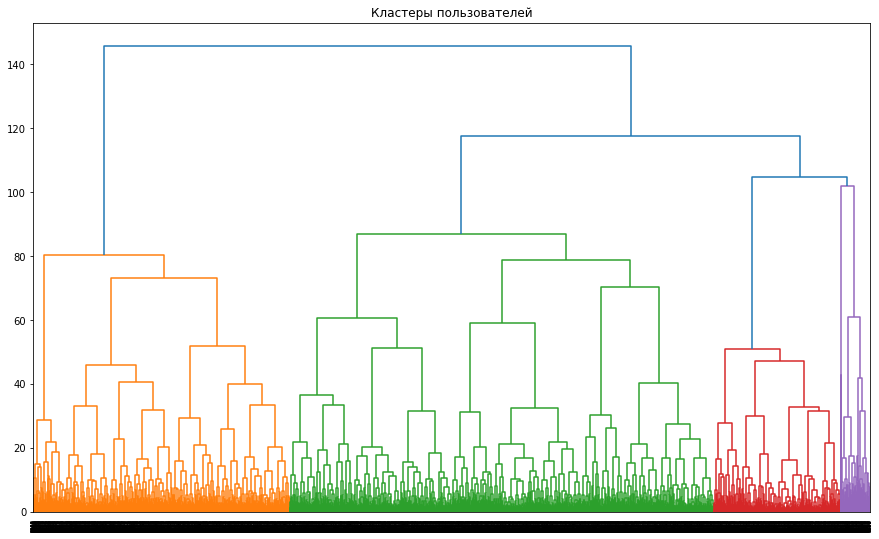

In [44]:
# Ячейка может занять время
plt.figure(figsize=(15, 9))  
dendrogram(linked, orientation='top')
plt.title('Кластеры пользователей')
plt.show()

In [45]:
kmeans = KMeans(n_clusters=4, random_state=0)
labels = kmeans.fit_predict(df_cl)
df['cluster'] = labels

In [46]:
df.head()

,userid,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,city_Ростов,city_Рыбинск,city_Ярославль,gender_Ж,gender_М,city_save,city_save_num,cluster
0,183012,850.0,25.0,1,59214.82,2,0,1,75719.14,1,0,1,0,1,0,Рыбинск,1,2
1,146556,861.0,37.0,5,850594.33,3,1,0,86621.77,0,0,1,0,1,0,Рыбинск,1,1
2,120722,892.0,30.0,0,147227.09,1,1,1,107683.34,0,0,1,0,1,0,Рыбинск,1,0
3,225363,866.0,51.0,5,1524746.26,2,0,1,174423.53,1,0,0,1,1,0,Ярославль,2,2
4,157978,730.0,34.0,5,174.00,1,1,0,67353.16,1,0,0,1,0,1,Ярославль,2,1


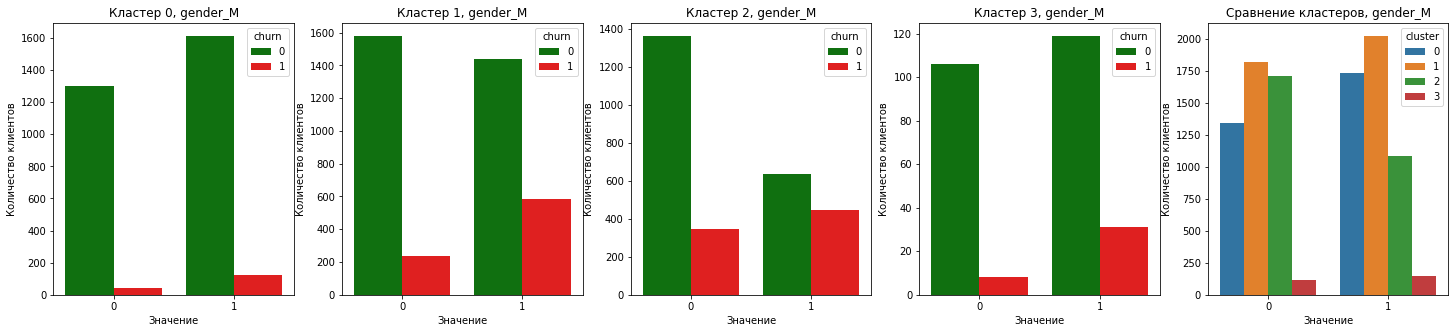

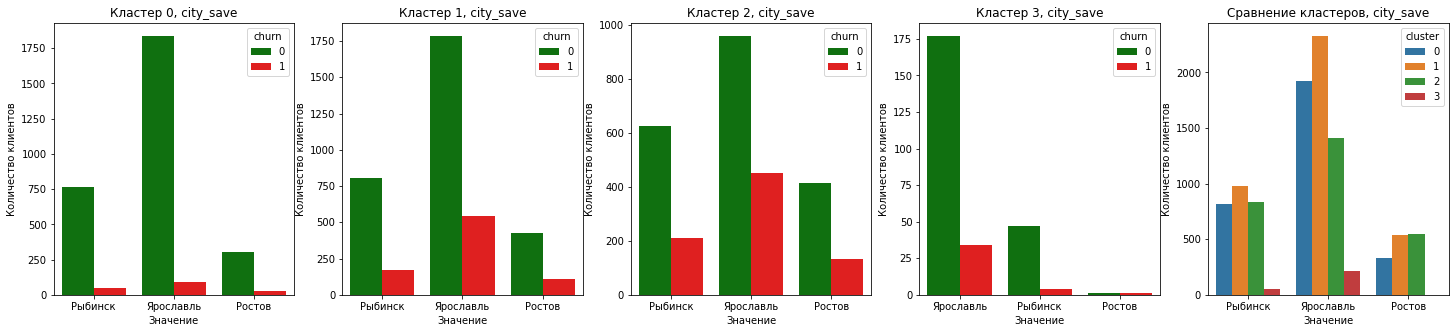

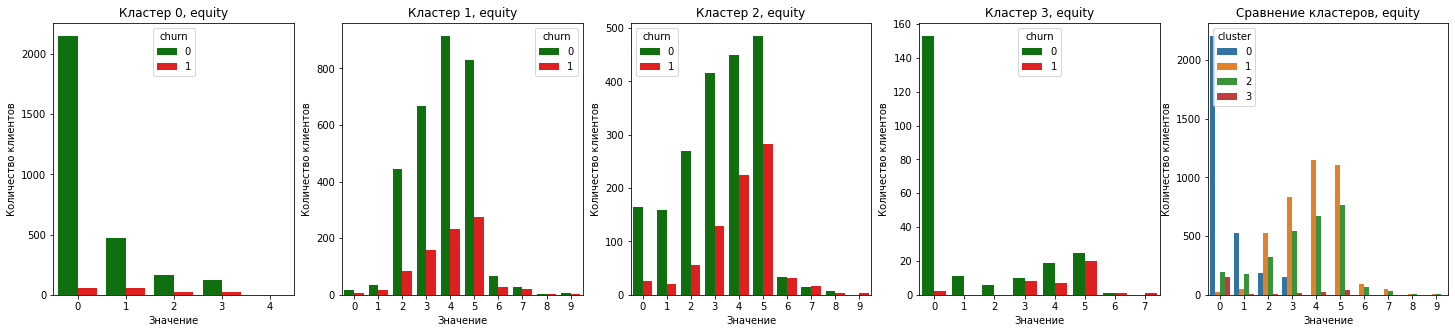

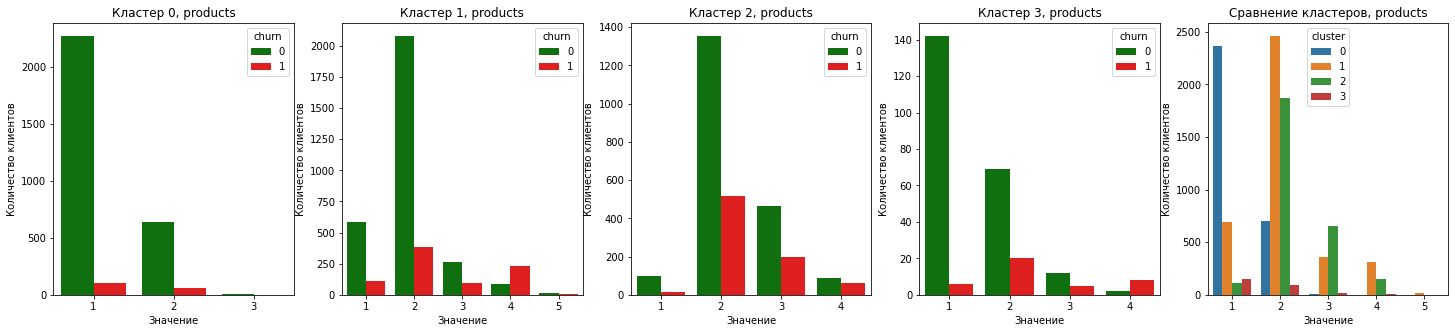

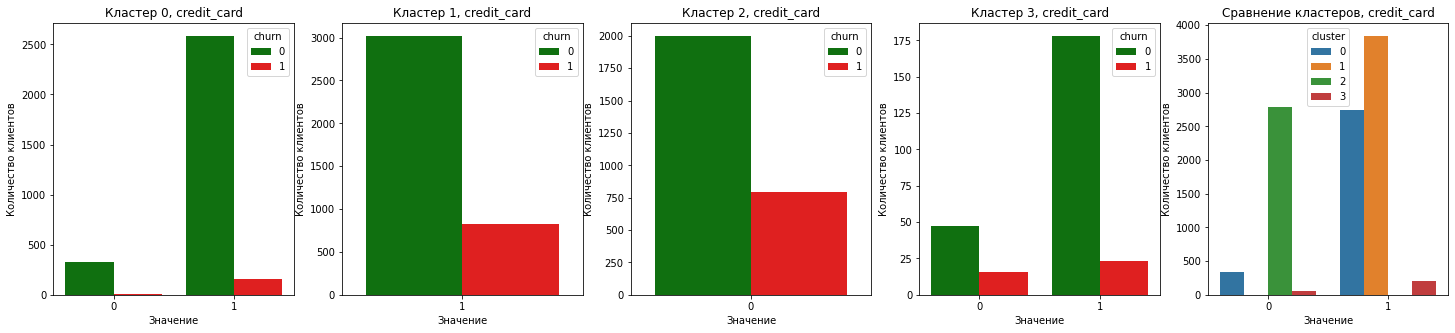

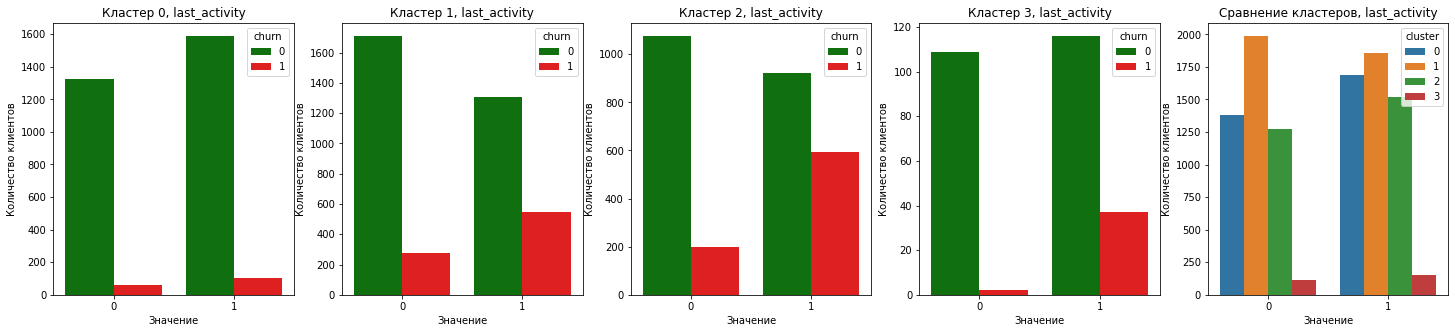

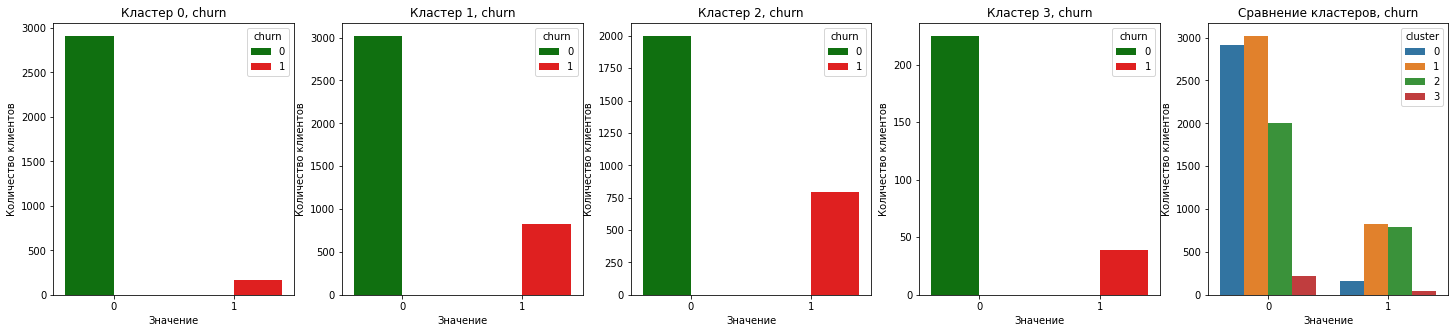

In [47]:
# Распределения категориальных признаков
for col in ['gender_М', 'city_save', 'equity', 'products', 'credit_card', 'last_activity', 'churn']:
    f, axs = plt.subplots(1, 5, figsize=(25, 5))

    sns.countplot(data=df.query('cluster == 0'), x=col, hue='churn', palette=["green", "red"], ax=axs[0])
    sns.countplot(data=df.query('cluster == 1'), x=col, hue='churn', palette=["green", "red"], ax=axs[1])
    sns.countplot(data=df.query('cluster == 2'), x=col, hue='churn', palette=["green", "red"], ax=axs[2])
    sns.countplot(data=df.query('cluster == 3'), x=col, hue='churn', palette=["green", "red"], ax=axs[3])
    sns.countplot(data=df, x=col, hue='cluster', ax=axs[4])
    for i in range(4):
        axs[i].set(xlabel='Значение', ylabel='Количество клиентов', title=f'Кластер {i}, {col}')
    axs[4].set(xlabel='Значение', ylabel='Количество клиентов', title=f'Сравнение кластеров, {col}')
    plt.show()
    

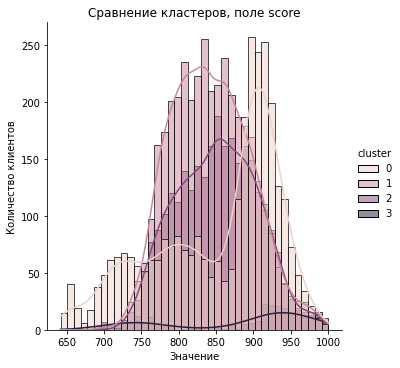

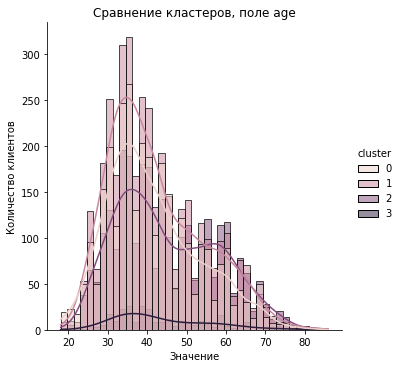

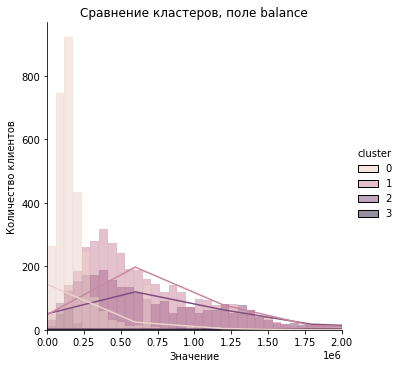

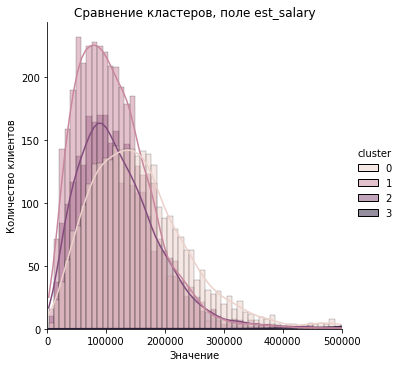

In [48]:
# Распределения количественных признаков
for col in ['score', 'age', 'balance', 'est_salary']:
    sns.displot(data=df, x=col, hue='cluster', kde=True, color='red')
    plt.xlabel('Значение')#, 
    plt.ylabel('Количество клиентов')
    plt.title(f'Сравнение кластеров, поле {col}')
    if col == 'balance':
        plt.xlim(0, 0.2e7)
    elif col == 'est_salary':
        plt.xlim(0, 0.5e6)
    plt.show()


In [49]:
# Выведем сводную таблицу по признакам для удовства сравнения
grouped_features = pd.pivot_table(df, index='cluster',
                    aggfunc={'userid': 'count',
                             'score': 'mean',
                             'products': 'mean',
                             'gender_М': 'mean',
                             'age': 'mean',
                             'equity': 'mean',
                             'balance': 'mean',
                             'credit_card': 'mean',
                             'last_activity': 'mean',
                             'est_salary': 'mean',
                             'churn': 'mean',
                             'city_Ростов': 'mean',
                             'city_Рыбинск': 'mean',
                             'city_Ярославль': 'mean'
                             })
grouped_features['%'] = grouped_features['userid'] / sum(grouped_features['userid']) * 100
grouped_features.sort_values('churn', ascending=False)

,age,balance,churn,city_Ростов,city_Рыбинск,city_Ярославль,credit_card,equity,est_salary,gender_М,last_activity,products,score,userid,%
cluster,,,,,,,,,,,,,,,
2,44.983888,8.613346e+05,0.283924,0.196205,0.298604,0.505192,0.000000,3.484783,121921.945199,0.388113,0.543502,2.302900,851.061941,2793,28.005615
1,42.095003,7.372124e+05,0.214211,0.138990,0.255075,0.605934,1.000000,3.831338,112977.628839,0.526549,0.482561,2.090578,842.663977,3842,38.524015
3,43.393939,3.349220e+06,0.147727,0.007576,0.193182,0.799242,0.761364,1.609848,822320.777765,0.568182,0.579545,1.579545,882.011364,264,2.647147
0,41.421275,2.074497e+05,0.053025,0.108003,0.265777,0.626220,0.891672,0.442095,156903.008468,0.564086,0.549772,1.231295,851.143787,3074,30.823223


Модель выбрала некоторые признаки как наиболее значимые для разделения на кластеры. В целом, у каждого кластера можно выделить отличительные особенности:
- **Кластер 2** - самый отточный (28.4%) и при этом возрастной кластер (средний возраст 45 лет), третий по величине - всего 28% от всех клиентов. У всех клиентов из этого кластера нет кредитной карты, больше чем в кластерах 3 и 0 баллов собственности, в среднем клиенты используют больше двух продуктов, имеют много средств на балансе, а среднее количество очков кредитного скоринга находится в районе 851 - этот пик мы видели на распределениях ранее 


- **Кластер 1** - менее отточный (21.4%) и при этом самый большой (38.5%). В кластере клиентам в среднем 42 года, все имеют кредитную карту, около 2 продуктов, также у клиентов в среднем больше всего баллов собственности, чем в остальных кластерах


- **Кластер 3** - имеет более низкий уровень оттока (14,7%), в нём всего около 2.6% клиентов. У клиентов из этого кластера также в среднем больше средств на балансе, им около 43 лет, почти все имеют кредитную карту, в среднем около около 1-2 баллов собственности, зарплата в среднем выше, чем у клиентов из других кластеров, они используют меньше продуктов, чем остальные, и имеют самый высокий средний скоринг - 882


- **Кластер 0** - наименее отточный кластер (5,3%), второй по величине (30.8%). Возраст клиентов - около 41 года, у большей части есть кредитная карта, при этом большинство клиентов имеет 0 баллов собственности, как правило используют один продукт и меньше всего средств на балансе


### EDA: Итог

Исходя из проведённого анализа, можно выделить следующие признаки как наиболее влияющие на отток:
- **Количество баллов собственности (equity)** - чем больше, тем выше отток
- **Количество используемых продуктов (products)** - чем больше, тем также выше отток
- **Баллы кредитного скоринга  (score)** - есть интервал, на котором много ушедших клиентов (в районе 850-925)
- Некоторое влияние также оказывает **активность (last_activity)** - активные, как ни странно, уходят чаще, а также **возраст (age)** - клиенты возрастом 50 до 60 лет имеют уходят чаще

Рассмотрим некоторые возможные срезы наиболее и наименее подверженных оттоку клиентов.

In [50]:
segments = df.query('equity >= 3 and products >= 3').agg({"churn":["mean","sum","count"]})
segments['seg2'] = df.query('score >= 850 and score <= 900 and last_activity == 1').agg({"churn":["mean","sum","count"]})
segments['seg3'] = df.query('age >= 50 and age <= 60 and products >= 2').agg({"churn":["mean","sum","count"]})
segments.columns = ['Клиенты с >= 3 очков собственности и продуктов', 
                     'Активные клиенты, 850-900 очков скоринга', 
                     'Клиенты возрастом 50-60 лет, >= 2 продуктов ']
segments

,Клиенты с >= 3 очков собственности и продуктов,"Активные клиенты, 850-900 очков скоринга","Клиенты возрастом 50-60 лет, >= 2 продуктов"
mean,0.426471,0.420015,0.330677
sum,522.000000,575.000000,415.000000
count,1224.000000,1369.000000,1255.000000


Изучим распределения признаков в полученных сегментах

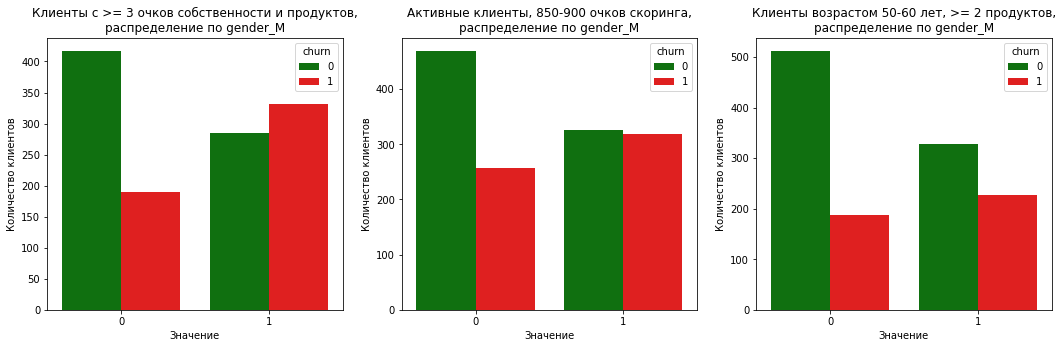

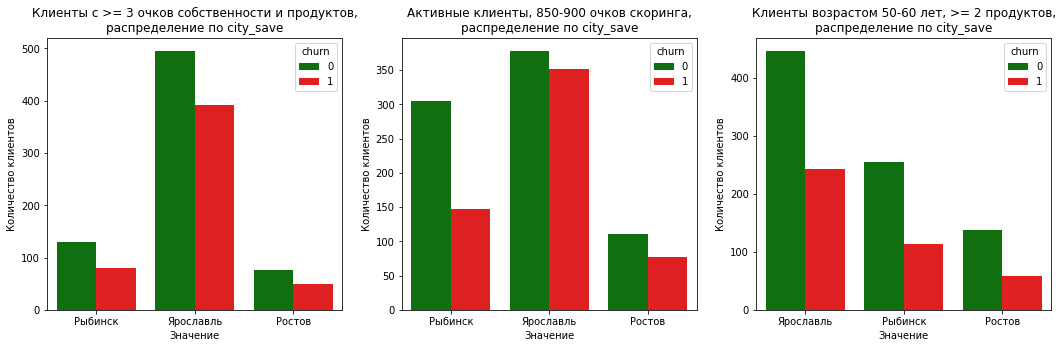

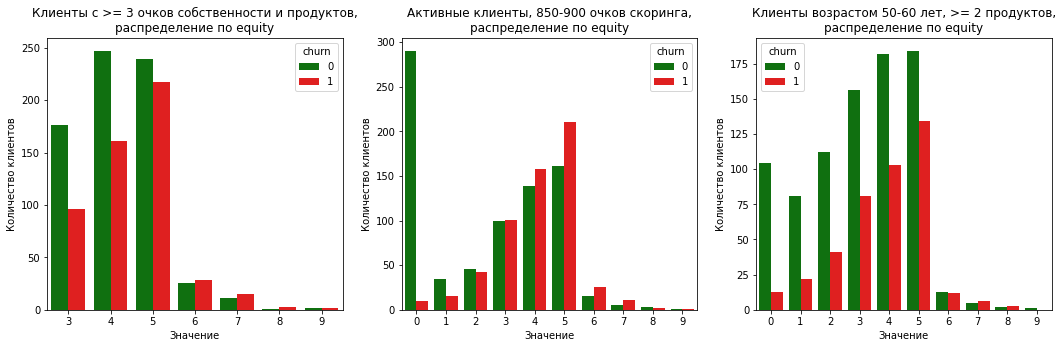

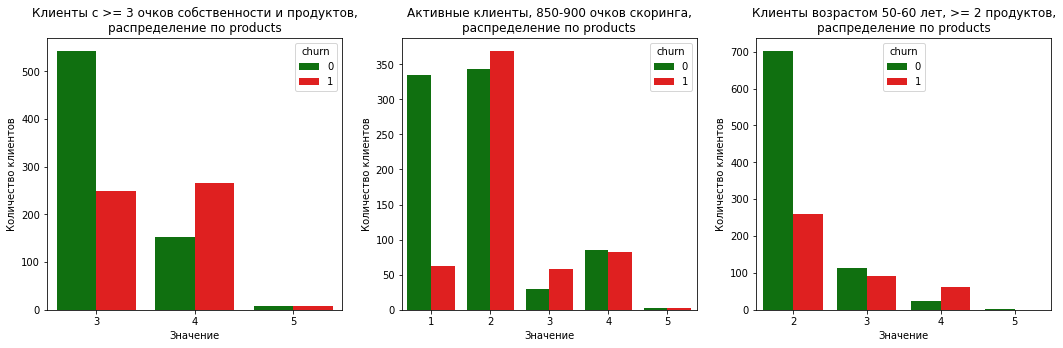

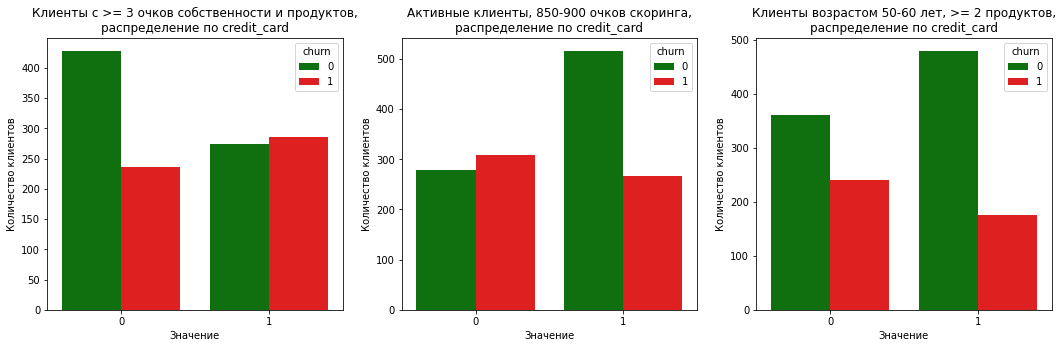

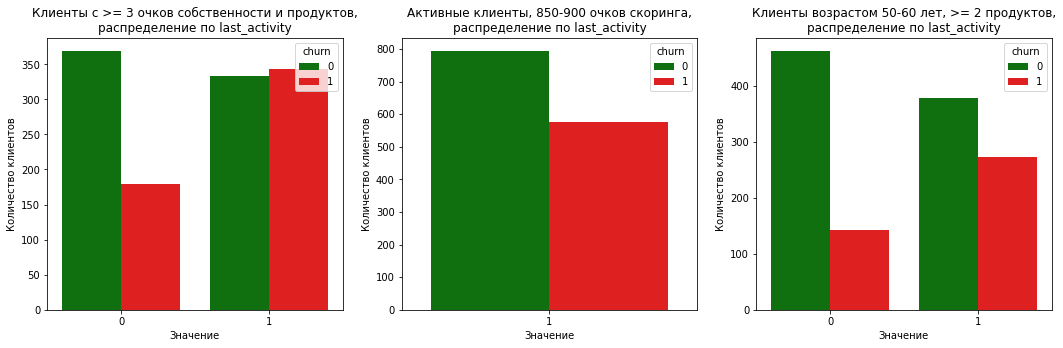

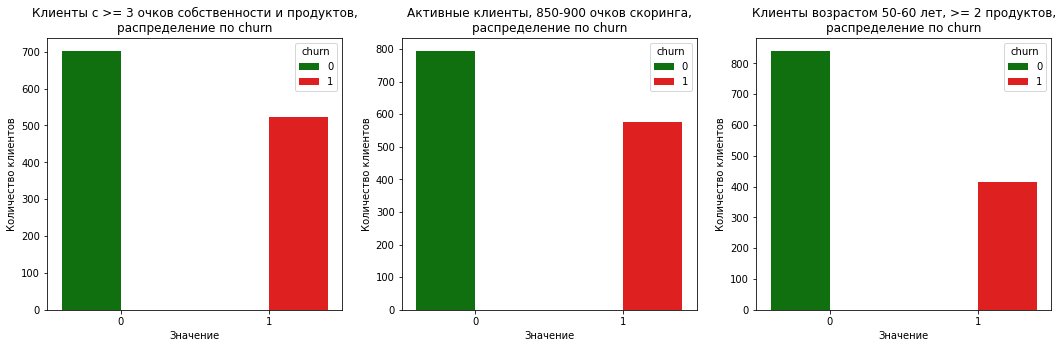

In [51]:
# Распределения категориальных признаков
for col in ['gender_М', 'city_save', 'equity', 'products', 'credit_card', 'last_activity', 'churn']:
    f, axs = plt.subplots(1, 3, figsize=(18, 5))

    sns.countplot(data=df.query('equity >= 3 and products >= 3'), x=col, 
                  hue='churn', palette=["green", "red"], ax=axs[0])
    sns.countplot(data=df.query('score >= 850 and score <= 900 and last_activity == 1'), x=col, 
                  hue='churn', palette=["green", "red"], ax=axs[1])
    sns.countplot(data=df.query('age >= 50 and age <= 60 and products >= 2'), x=col, 
                  hue='churn', palette=["green", "red"], ax=axs[2])
    
    axs[0].set_title(f'Клиенты с >= 3 очков собственности и продуктов,\nраспределение по {col}')
    axs[1].set_title(f'Активные клиенты, 850-900 очков скоринга,\nраспределение по {col}')
    axs[2].set_title(f'Клиенты возрастом 50-60 лет, >= 2 продуктов,\nраспределение по {col}')
    for i in range(3):
        axs[i].set_xlabel('Значение')
        axs[i].set_ylabel('Количество клиентов')
    plt.show()
    

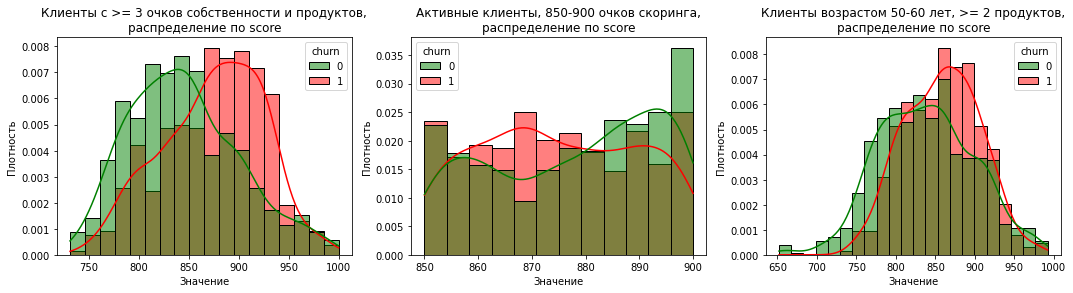

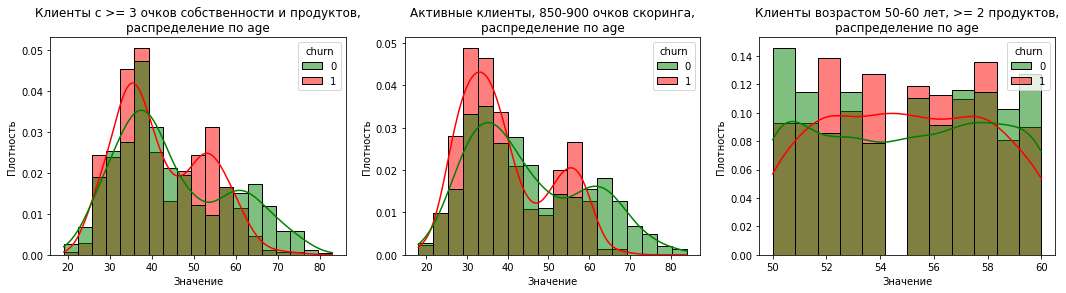

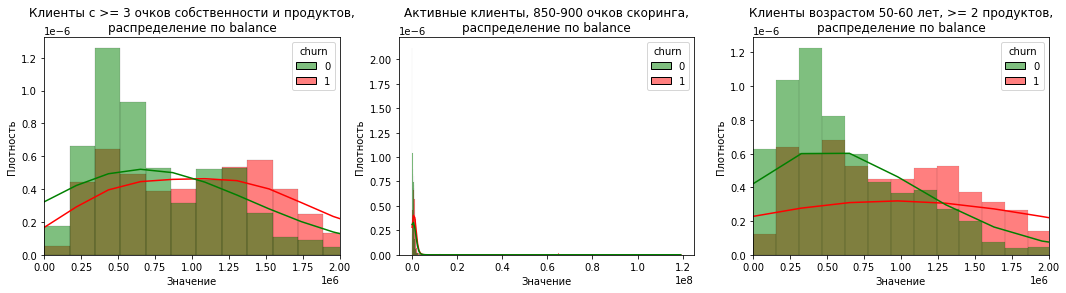

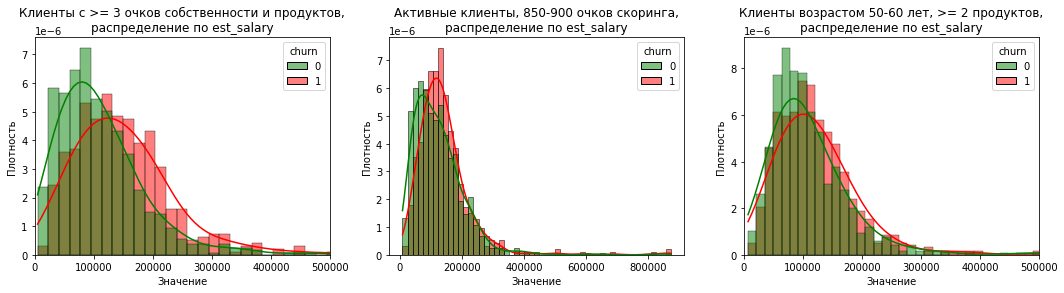

In [52]:
# Распределения количественных признаков
for col in ['score', 'age', 'balance', 'est_salary']:
    f, axs = plt.subplots(1, 3, figsize=(18, 4))
    
    
    sns.histplot(data=df.query('equity >= 3 and products >= 3'), 
                 x=col, kde=True, stat='density', common_norm=False, 
                 hue='churn', palette=['green', 'red'], ax=axs[0])
    sns.histplot(data=df.query('score >= 850 and score <= 900 and last_activity == 1'), 
                 x=col, kde=True, stat='density', common_norm=False, 
                 hue='churn', palette=['green', 'red'], ax=axs[1])
    sns.histplot(data=df.query('age >= 50 and age <= 60 and products >= 2'), 
                 x=col, kde=True, stat='density', common_norm=False, 
                 hue='churn', palette=['green', 'red'], ax=axs[2])

    axs[0].set_title(f'Клиенты с >= 3 очков собственности и продуктов,\nраспределение по {col}')
    axs[1].set_title(f'Активные клиенты, 850-900 очков скоринга,\nраспределение по {col}')
    axs[2].set_title(f'Клиенты возрастом 50-60 лет, >= 2 продуктов,\nраспределение по {col}')
    for i in range(3):
        axs[i].set_xlabel('Значение')
        axs[i].set_ylabel('Плотность')
    if col == 'balance':
        axs[0].set_xlim(0, 0.2e7)
        axs[2].set_xlim(0, 0.2e7)
    elif col == 'est_salary':
        axs[0].set_xlim(0, 0.5e6)
        axs[2].set_xlim(0, 0.5e6)

**В целом, результаты подтвердились - при фильтрации по данным признакам чётко выделяются сегменты с довольно большим оттоком (33-42%)** 

    Сегмент людей, имеющих от трёх продуктов и от трёх баллов собственности 

    Сегмент активных клиентов, имеющих от 850 до 900 баллов скоринга

    Сегмент клиентов предпенсионного возраста (50-60 лет), пользующихся двумя и более продуктами

Все эти сегменты являются важными, при этом количество клиентов в каждом из них позволяет взять их в работу, чтобы узнать о "болях" каждого из сегментов и сгенерировать варианты для решения сложившихся проблем, тем самым улучшив качество продукта.

## Проверка гипотез

**Для первых двух поставленных гипотез мы будем использовать критерий Стьюдента (t-тест)** - статистический метод, который позволяет сравнивать средние значения двух совокупностей и на основе результатов теста делать заключение о том, различаются ли они друг от друга статистически или нет. Мы будем пользоваться методом **ttest_ind()**.

Для того, чтобы его применять, должны соблюдаться несколько условий:
- Генеральные совокупности не должны зависеть друг от друга.
- Выборочные средние должны быть нормально распределены -  благодаря ЦПТ, если размер выборки составляет хотя бы несколько десятков значений (а у нас явно больше), выборочные средние, которые можно получить из одной и той же генеральной совокупности, будут распределены нормально вокруг истинного среднего этой совокупности
- Дисперсии рассматриваемых генеральных совокупностей должны быть равны - если выборки достаточно велики (30 и больше значений) и примерно равны по размеру между собой, то даже если дисперсии на самом деле не равны, тест редко ошибается. К тому же, в ttest_ind() есть параметр equal_var, отвечающий за равенство дисперсий - мы укажем значение False

При использовании данного теста нулевая и альтернативная гипотезы формируются следующим образом:

$$ H_0: µ_1 = µ_2; $$
$$ H_1: µ_1 ≠ µ_2, $$
Где µ - это среднее совокупности

#### Гипотеза I: Уровень дохода клиента влияет на отток
- **H0:** Средний уровень дохода ушедших и оставшихся клиентов **одинаков**
- **H1:** Средний уровень дохода ушедших и оставшихся клиентов **отличен**
- **alpha** = 0.05

Проверим гипотезу с помощью **ttest_ind()**

In [53]:
churn_sal = df[(df['churn'] == 1)]['est_salary']
not_churn_sal = df[(df['churn'] == 0)]['est_salary']

print('Средний доход ушедших:', churn_sal.mean())
print('Средний доход оставшихся:', not_churn_sal.mean())

alpha = 0.05
results = ttest_ind(churn_sal, not_churn_sal, equal_var=False)

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Средний доход ушедших: 148357.48315731573
Средний доход оставшихся: 147674.63788105457
p-value: 0.8354803526840116
Не получилось отвергнуть нулевую гипотезу


Исходя из результатов, принимаем нулевую гипотезу: **средний уровень дохода ушедших и оставшихся клиентов схож**.


#### Гипотеза II: Возраст клиента влияет на отток
- **H0:** Средний возраст ушедших и оставшихся клиентов **одинаков**
- **H1:** Средний возраст ушедших и оставшихся клиентов клиентов **отличен**
- **alpha** = 0.05

Проверим гипотезу с помощью **ttest_ind()**

In [54]:
churn_age = df[(df['churn'] == 1)]['age']
not_churn_age = df[(df['churn'] == 0)]['age']

print('Средний возраст ушедших:', churn_age.mean())
print('Средний возраст оставшихся:', not_churn_age.mean())

alpha = 0.05
results = ttest_ind(churn_age, not_churn_age, equal_var=False)

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Средний возраст ушедших: 41.42959295929593
Средний возраст оставшихся: 43.02084610668302
p-value: 7.536127357312234e-08
Отвергаем нулевую гипотезу


Исходя из результатов, отвергаем нулевую гипотезу: **средний возраст ушедших и оставшихся клиентов клиентов отличен**


Исходя из распределений в EDA, хочется проверить следующую гипотезу
#### Гипотеза III: кредитный скоринг клиента влияет на отток
- **H0:** Средний скоринг ушедших и оставшихся клиентов **одинаков**
- **H1:** Средний скоринг ушедших и оставшихся клиентов клиентов **отличен**
- **alpha** = 0.05

Проверим гипотезу с помощью **ttest_ind()**

In [55]:
churn_score = df[(df['churn'] == 1)]['score']
not_churn_score = df[(df['churn'] == 0)]['score']

print('Средний скоринг ушедших:', churn_score.mean())
print('Средний скоринг оставшихся:', not_churn_score.mean())

alpha = 0.05
results = ttest_ind(churn_score, not_churn_score, equal_var=False)

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Средний скоринг ушедших: 863.3619361936194
Средний скоринг оставшихся: 845.3961986511342
p-value: 1.3179430198200596e-37
Отвергаем нулевую гипотезу


Исходя из результатов, отвергаем нулевую гипотезу: **средний скоринг ушедших и оставшихся клиентов отличен**

**Для проверки следующий гипотезы будем использовать другой тест, сравнивающий вероятности двух биномиальных распределений.**

Пусть в двух генеральных совокупностях проводятся независимые испытания, в каждом из которых событие $A$ может появиться – с неизвестной вероятностью $p_1$ в первой совокупности и с неизвестной вероятностью $p_2$ – во второй. По выборочным сериям испытаний объёмами $n_1$ и $n_2$ найдены соответствующие относительные частоты:

$\omega_1(A) = \frac{m_1}{n_1}$, $\omega_2(A) = \frac{m_2}{n_2}$, где, $m_1,\,m_2$ – фактическое число появлений события $A$ в 1-й и во 2-й выборке.

Требуется оценить, значимо или незначимо отличаются друг от друга относительные частоты. Незначимое отличие объяснимо случайными факторами и справедливостью гипотезы $H_0: p_1 = p_2$.


Т.к. при достаточно большой выборке биномиальное распределение близко к нормальному, то для проверки этой гипотезы используют критерий:
    $Z = \frac
    {\frac{m_1}{n_1} - \frac{m_2}{n_2}}
    {\sqrt{
    \frac{m_1+m_2}{n_1+n_2} \cdot
    \left(1 - \frac{m_1+m_2}{n_1+n_2}\right)
    \left(\frac{1}{n_1} + \frac{1}{n_2}\right)}}$, где,
    
    
$m_1$, $m_2$ – случайное количество появлений события $A$ в 1-й и во 2-й выборке соответственно.

Для конкурирующей гипотезы $H_1: p_1 < p_2$ строится левосторонняя критическая область.

Для конкурирующей гипотезы $H_1: p_1 > p_2$ строится правосторонняя критическая область.

Для конкурирующей гипотезы $H_1: p_1 ≠ p_2$ строится двусторонняя критическая область.
    
Критическое значение отыскивается из соотношения:

$\Phi(z_к) = \frac{1-2\alpha}{2}$ для односторонней области и 

$\Phi(z_к) = \frac{1-\alpha}{2}$ для двусторонней области, где

$\alpha$ – выбранный уровень значимости, $\Phi(z)$ – функция Лапласа.
    
    
Если наблюдаемое значение критерия $z_н$ попадает в критическую область, то гипотеза $H_0: p_1 = p_2$ отвергается.

#### Гипотеза IV: Активность клиента влияет на отток
- **p1, p2** - вероятность того, что ушедший и оставшийся клиент лоялен соответственно
- **H0:** **p1 = p2**
- **H1:**  **p1 ≠ p2**
- **alpha** = 0.05

Критическое значение двусторонней критической области найдём из соотношения $\displaystyle \Phi(z_к) = \frac{1-\alpha}{2}$

In [56]:
n1, n2 = df[(df['churn'] == 1)]['last_activity'].count(), df[(df['churn'] == 0)]['last_activity'].count()
m1 = df[(df['churn'] == 1) & (df['last_activity'] == 1)]['last_activity'].count() 
m2 = df[(df['churn'] == 0) & (df['last_activity'] == 1)]['last_activity'].count()
alpha = 0.05
w1, w2 = m1 / n1, m2 / n2
print('Частоты:', w1, w2)

phi = (1 - alpha) / 2
Zk = norm.ppf(phi + 0.5)
print(f'{Zk = :.2f}')

Zn = (m1/n1 - m2/n2) / np.sqrt((m1+m2)/(n1+n2) * (1 - (m1+m2)/(n1+n2)) * (1/n1 + 1/n2))  
print(f'{Zn = :.2f}')

if Zn > abs(Zk):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Частоты: 0.7024202420242024 0.48289393010423054
Zk = 1.96
Zn = 16.95
Отвергаем нулевую гипотезу


Исходя из результатов, отвергаем нулевую гипотезу: **p1 ≠ p2**, а значит различие относительных частот, скорее всего, не случайно, следовательно **активность клиента влияет на отток**.


### Вывод

Перед началом исследовательского анализа данных мы провели предобработку: привели названия столбцов в нижний регистр, проверили корректность заполнения данных, закодировали необходимые столбцы методом one-hot. Помимо этого мы столкнулись с пропусками в возрасте (данных строк оказалось немного, поэтому они были удалены из датасета), большим количеством пропусков в значениях баланса клиентов - для замены пропусков данные были сгруппированы по нескольким признакам, для каждой группы была определена медиана баланса и произведена замена - это позволило нам сохранить нормальный вид распределения.

В ходе исследовательского анализа данных было необходимо изучить, какие признаки оказывают наибольшее влияние на отток клиентов - это было сделано сразу несколькими способами:
- Изучены распределения всех признаков, а также распределения признаков в разрезе оттока клиентов
- Построена матрица корреляций признаков, выявлены коррелирующие с оттоком признаки
- Обучено несколько моделей классификации клиентов на ушедших/оставшихся с разной логикой работы, изучены важности признаков для каждой из модели, приняты ко вниманию наиболее важные признаки у моделей с хорошим качеством
- Рассмотрена кластеризация клиентов методом k-средних на 4 кластера, изучены признаки, которые были наиболее приоритетными при разбиении клиентов на группы, найдены отличительные особенности каждого кластера

В результате изучения данных различными способами, были выявлены несколько наиболее важных признаков: количество баллов собственности, количество используемых продуктов, баллы кредитного скоринга, а также активность и возраст, по этим признакам было построено 3 проблемных сегмента, необходимых для проработки отделу маркетинга и иным командам: 

1. **Сегмент людей, имеющих от трёх продуктов и от трёх баллов собственности** - 42% оттока, всего 1224 клиента
2. **Сегмент активных клиентов, имеющих от 850 до 900 баллов скоринга** - 42% оттока, всего 1369 клиентов
3. **Сегмент клиентов предпенсионного возраста (50-60 лет), пользующихся двумя и более продуктами** - 33% оттока, всего 1255 клиентов


Помимо прочего, настораживает ситуация по продуктам - если клиент использует большое количество продуктов, то, напротив, он должен быть более лоялен к банку, а значит реже уходить, иначе зачем ими пользоваться. Возможно, банк со временем навязывает клиенту некоторые продукты и вынуждает ими пользоваться (что объясняет уход среди активных клиентов), отчего тот устаёт и принимает решение об уходе. Также важно рассмотреть группу людей возрастом 50-60 лет, поскольку среди них также наблюдается высокий отток - вероятно, имеет смысл взять в работу формирование специальных предложенй для аудитории данного возраста. 

Наконец, было рассмотрено несколько статистических гипотез, подтверждающих часть выводов из исследовательского анализа данных, в результате выяснено, что:
- Средний уровень дохода ушедших и оставшихся клиентов не имеет статистически значимых различий 
- Средний возраст ушедших и оставшихся клиентов клиентов отличается
- Лояльность клиента статистически значимо влияет на отток.

**Рекомендации для бизнеса**

Все выявленные в ходе исследования отточные сегменты являются важными к рассмотрению, посколько позволят узнать о "болях" каждого из сегментов, проблемах при использовании продуктов, и дадут знания для правильного решения проблем.

В общем и целом, следует:
- Установить причину оттока среди клиентов, пользующихся большим числом продуктов (1 сегмент)
- Изучить, какие предложения имеет банк для людей, набравших 850-900 баллов скоринга (2 сегмент)
- Рассмотреть отдельно предложения банка клиентам старшего поколения (3 сегмент)
- Поддерживать активных клиентов, которые пользуются услугами продолжительное время - возможно, предлагать продукты по специальным условиям, тем самым давая клиенту понимание о его ценности для нас (отток среди активных пользователей)